<a href="https://colab.research.google.com/github/anjanhatuwal/anjanhatuwal.github.io/blob/main/Big_Data_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install pyspark py4j


In [27]:
!java -version

openjdk version "11.0.27" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [28]:
from pyspark.sql import SparkSession


In [29]:
spark=SparkSession.builder.appName('Analysis').getOrCreate()

In [30]:
FirstDataFrame=spark.read.csv('/customer_purchases.csv',header=True,inferSchema=True)
FirstDataFrame.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- SpendingScore: integer (nullable = true)
 |-- PurchaseCategory: string (nullable = true)
 |-- TotalPurchases: integer (nullable = true)
 |-- PurchaseAmount: double (nullable = true)
 |-- Outcome: integer (nullable = true)



In [31]:
FirstDataFrame.show(5)

+----------+---+------+------------+-------------+----------------+--------------+--------------+-------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|Outcome|
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------+
|         1| 49|Female|           0|           94|          Sports|            20|           0.0|      1|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|      0|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|      0|
|         4| 35|Female|       71190|           47|     Electronics|             0|         40.42|      0|
|         5|  0|  Male|       28451|           84|         Fashion|            16|        110.01|      1|
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------+
only showing top 5 rows



In [32]:

from pyspark.sql.functions import when, col
median_spending = FirstDataFrame.filter(
    (col("SpendingScore") != 0) & (col("SpendingScore").isNotNull())
).approxQuantile("SpendingScore", [0.5], 0.0)[0]

median_purchases = FirstDataFrame.filter(
    (col("TotalPurchases") != 0) & (col("TotalPurchases").isNotNull())
).approxQuantile("TotalPurchases", [0.5], 0.0)[0]

print("Computed Median SpendingScore:", median_spending)
print("Computed Median TotalPurchases:", median_purchases)


Computed Median SpendingScore: 50.0
Computed Median TotalPurchases: 10.0


In [33]:
SecondDataFrame = FirstDataFrame.withColumn(
    "SpendingScore", when(
        (col("SpendingScore") == 0) | (col("SpendingScore").isNull()),
        median_spending
    ).otherwise(col("SpendingScore"))
).withColumn(
    "TotalPurchases", when(
        (col("TotalPurchases") == 0) | (col("TotalPurchases").isNull()),
        median_purchases
    ).otherwise(col("TotalPurchases"))
)
updated_rows = SecondDataFrame.filter(
    (col("SpendingScore") == median_spending) | (col("TotalPurchases") == median_purchases)
)
print("Updated rows after replacement with median values:")
updated_rows.show()

Updated rows after replacement with median values:
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|Outcome|
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------+
|         4| 35|Female|       71190|         47.0|     Electronics|          10.0|         40.42|      0|
|        23| 50|Female|       48073|          5.0|         Fashion|          10.0|        246.99|      0|
|        26| 31|Female|       98459|         85.0|           Books|          10.0|         45.53|      0|
|        38| 45|  Male|       60916|         84.0|         Grocery|          10.0|        136.17|      1|
|        55| 50|  Male|       22815|         42.0|     Electronics|          10.0|          6.41|      0|
|        60| 28|Female|       75071|         50.0|  Home & Kitchen|           5.0|        468.06|    

In [34]:
ThirdDataFrame = SecondDataFrame.filter(
    (col("Age").isNotNull()) & (col("Age") != 0) &
    (col("AnnualIncome").isNotNull()) & (col("AnnualIncome") != 0) &
    (col("PurchaseAmount").isNotNull()) & (col("PurchaseAmount") != 0)
)

print("ThirdDataFrame after removing rows with missing values in Age, AnnualIncome, or PurchaseAmount:")
ThirdDataFrame.show(5)


ThirdDataFrame after removing rows with missing values in Age, AnnualIncome, or PurchaseAmount:
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|Outcome|
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------+
|         2| 34|Female|       89715|         80.0|         Fashion|           1.0|        236.01|      0|
|         3| 39|Female|       42910|         85.0|         Fashion|           8.0|         50.24|      0|
|         4| 35|Female|       71190|         47.0|     Electronics|          10.0|         40.42|      0|
|         6| 40|  Male|       65294|         65.0|         Fashion|          15.0|         75.91|      0|
|         9| 42|Female|       74467|         18.0|  Home & Kitchen|          12.0|         57.59|      0|
+----------+---+------+------------+-------------+------

In [35]:
total_rows_second = SecondDataFrame.count()
total_rows_third = ThirdDataFrame.count()

rows_removed = total_rows_second - total_rows_third
print("Total number of rows removed from SecondDataFrame:", rows_removed)


Total number of rows removed from SecondDataFrame: 97


In [36]:
from pyspark.sql.functions import variance, stddev, col, min, max, mean

ThirdDataFrame.select("PurchaseAmount").describe().show()

median_purchase = ThirdDataFrame.approxQuantile("PurchaseAmount", [0.5], 0.0)[0]
print("Median PurchaseAmount:", median_purchase)

variance_purchase = ThirdDataFrame.select(variance("PurchaseAmount")).collect()[0][0]
stddev_purchase = ThirdDataFrame.select(stddev("PurchaseAmount")).collect()[0][0]

print("Variance of PurchaseAmount:", variance_purchase)
print("Standard Deviation of PurchaseAmount:", stddev_purchase)


+-------+------------------+
|summary|    PurchaseAmount|
+-------+------------------+
|  count|               903|
|   mean|253.57815060908118|
| stddev| 146.5466731529852|
|    min|              5.91|
|    max|            499.97|
+-------+------------------+

Median PurchaseAmount: 254.95
Variance of PurchaseAmount: 21475.927412207875
Standard Deviation of PurchaseAmount: 146.5466731529852


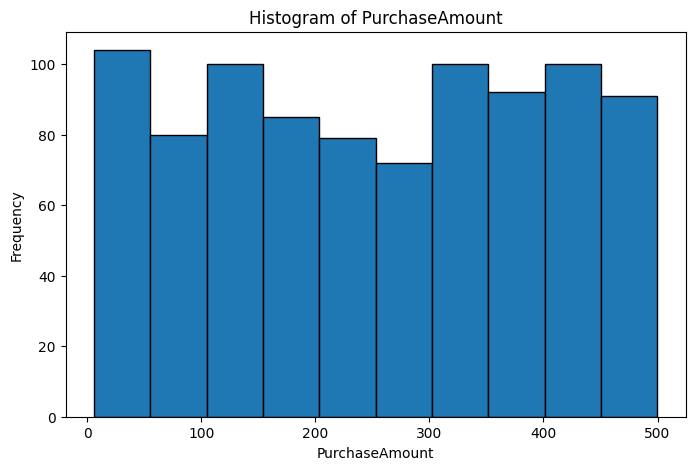

In [37]:
import matplotlib.pyplot as plt
purchase_hist = ThirdDataFrame.select("PurchaseAmount").rdd.flatMap(lambda x: x).histogram(10)
bins = purchase_hist[0]
counts = purchase_hist[1]
plt.figure(figsize=(8, 5))
plt.bar(bins[:-1], counts, width=[bins[i+1]-bins[i] for i in range(len(bins)-1)], align='edge', edgecolor='black')
plt.xlabel('PurchaseAmount')
plt.ylabel('Frequency')
plt.title('Histogram of PurchaseAmount')
plt.show()

In [38]:

quartiles = ThirdDataFrame.approxQuantile("TotalPurchases", [0.25, 0.5, 0.75], 0.0)
q1, q2, q3 = quartiles

print("Q1 (25th percentile):", q1)
print("Q2 (Median, 50th percentile):", q2)
print("Q3 (75th percentile):", q3)


Q1 (25th percentile): 6.0
Q2 (Median, 50th percentile): 10.0
Q3 (75th percentile): 15.0


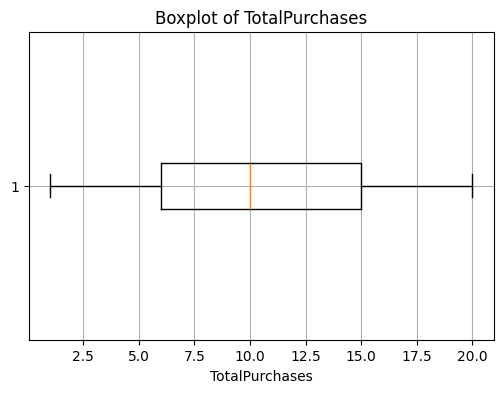

In [39]:
import matplotlib.pyplot as plt
purchases_pd = ThirdDataFrame.select("TotalPurchases").toPandas()
plt.figure(figsize=(6, 4))
plt.boxplot(purchases_pd["TotalPurchases"], vert=False)
plt.title("Boxplot of TotalPurchases")
plt.xlabel("TotalPurchases")
plt.grid(True)
plt.show()


In [40]:
correlation_value = ThirdDataFrame.corr("PurchaseAmount", "SpendingScore")
print("Pearson Correlation between PurchaseAmount and SpendingScore:", correlation_value)


Pearson Correlation between PurchaseAmount and SpendingScore: -0.01624061063226108


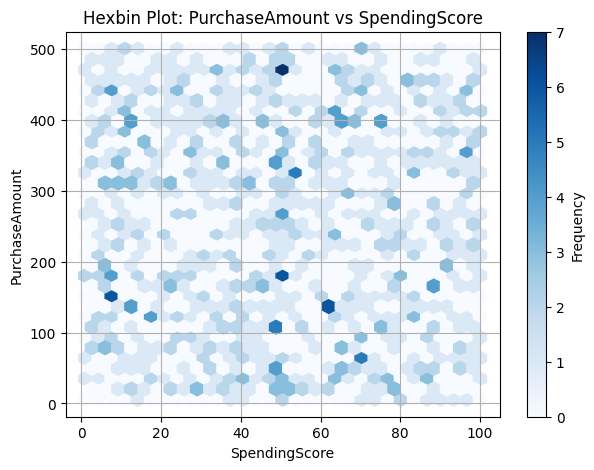

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = ThirdDataFrame.select("PurchaseAmount", "SpendingScore").toPandas()
plt.figure(figsize=(7, 5))
plt.hexbin(plot_df['SpendingScore'], plot_df['PurchaseAmount'], gridsize=30, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel("SpendingScore")
plt.ylabel("PurchaseAmount")
plt.title("Hexbin Plot: PurchaseAmount vs SpendingScore")
plt.grid(True)
plt.show()

In [42]:
ThirdDataFrame.createOrReplaceTempView("CustomerData")
filtered_results = spark.sql("""
    SELECT Age, SpendingScore
    FROM CustomerData
    WHERE Age < 50 AND SpendingScore > 100
""")
filtered_results.show()


+---+-------------+
|Age|SpendingScore|
+---+-------------+
+---+-------------+



In [43]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
indexer_gender = StringIndexer(inputCol="Gender", outputCol="GenderIndexed")
indexer_category = StringIndexer(inputCol="PurchaseCategory", outputCol="CategoryIndexed")
indexed_df = indexer_gender.fit(ThirdDataFrame).transform(ThirdDataFrame)
indexed_df = indexer_category.fit(indexed_df).transform(indexed_df)
feature_cols = ["Age", "AnnualIncome", "SpendingScore", "TotalPurchases", "PurchaseAmount", "GenderIndexed", "CategoryIndexed"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_df = assembler.transform(indexed_df).select("features", "Outcome")
train_data, test_data = final_df.randomSplit([0.7, 0.3], seed=42)
dt = DecisionTreeClassifier(labelCol="Outcome", featuresCol="features")
dt_model = dt.fit(train_data)
predictions = dt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="f1")
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)
print("Decision Tree Classifier Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Decision Tree Classifier Evaluation:
Accuracy: 0.9615384615384616
Precision: 0.9618167539666201
Recall: 0.9615384615384616
F1-Score: 0.9616544741560322


In [44]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr = LogisticRegression(labelCol="Outcome", featuresCol="features")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)
f1 = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="f1").evaluate(predictions)
print("Logistic Regression Classifier Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Logistic Regression Classifier Evaluation:
Accuracy: 0.8461538461538461
Precision: 0.8393047747811855
Recall: 0.8461538461538463
F1-Score: 0.8407140914373314


In [45]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["AnnualIncome"], outputCol="features")
regression_data = assembler.transform(ThirdDataFrame).select("features", "PurchaseAmount")

lr = LinearRegression(featuresCol="features", labelCol="PurchaseAmount")
lr_model = lr.fit(regression_data)

training_summary = lr_model.summary

r2 = training_summary.r2
rmse = training_summary.rootMeanSquaredError
mae = training_summary.meanAbsoluteError

print("Linear Regression Evaluation Metrics:")
print("R-squared (R2):", r2)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Linear Regression Evaluation Metrics:
R-squared (R2): 0.009299228520803338
Root Mean Squared Error (RMSE): 145.7829076142127
Mean Absolute Error (MAE): 127.82519260085184
